In [18]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import lightgbm as lgb
from xgboost import XGBClassifier

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------
# Data Loading and Preprocessing
# ---------------------------
def preprocess_data(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    if X.isnull().sum().sum() > 0:
        X = X.fillna(X.median())
    return X, y

In [ ]:
# ---------------------------
# Genetic Algorithm + GridSearch for Feature and Hyperparameter Selection
# ---------------------------
class GeneticFeatureHyperparamSelector:
    def __init__(self, estimator, param_grid,
                 population_size=20, generations=8,
                 crossover_prob=0.8, mutation_prob=0.1,
                 scoring='roc_auc', cv=3, verbose=0, n_jobs=1, random_state=42):
        """
        estimator: sklearn-like estimator instance
        param_grid: dict for GridSearchCV
        population_size, generations: GA parameters
        scoring: scoring metric for inner GridSearch
        cv: number of cross-validation folds
        n_jobs: number of parallel jobs for GridSearch
        """
        self.estimator = estimator
        self.param_grid = param_grid
        self.population_size = population_size
        self.generations = generations
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.scoring = scoring
        self.cv = cv
        self.verbose = verbose
        self.n_jobs = n_jobs
        self.random_state = random_state

        self.best_features_ = None
        self.best_params_ = None
        self.best_score_ = -np.inf
        self.generational_best_scores = []

    def _initialize_population(self, n_features):
        rng = np.random.RandomState(self.random_state)
        population = []
        for _ in range(self.population_size):
            indiv = rng.choice([0, 1], size=n_features, p=[0.7, 0.3])
            if indiv.sum() == 0:
                indiv[rng.randint(0, n_features)] = 1
            population.append(indiv)
        return population

    def _fitness(self, individual, X, y):
        if individual.sum() == 0:
            return -np.inf, None
        X_sel = X.iloc[:, individual.astype(bool)]
        
        grid = GridSearchCV(
            estimator=self.estimator,
            param_grid=self.param_grid,
            scoring=self.scoring,
            cv=self.cv,
            n_jobs=self.n_jobs,
            verbose=0
        )
        grid.fit(X_sel, y)
        return grid.best_score_, grid.best_params_

    def _crossover(self, a, b):
        if np.random.rand() < self.crossover_prob:
            pt = np.random.randint(1, len(a)-1)
            ca = np.concatenate([a[:pt], b[pt:]])
            cb = np.concatenate([b[:pt], a[pt:]])
            return ca, cb
        return a.copy(), b.copy()

    def _mutate(self, indiv):
        m = indiv.copy()
        for i in range(len(m)):
            if np.random.rand() < self.mutation_prob:
                m[i] = 1 - m[i]
        if m.sum() == 0:
            m[np.random.randint(0, len(m))] = 1
        return m

    def fit(self, X, y):
        n_features = X.shape[1]
        population = self._initialize_population(n_features)

        best_indiv = None
        best_params = None
        best_score = -np.inf

        for gen in range(self.generations):
            fitnesses = []
            params_list = []
            
            for indiv in population:
                try:
                    score, params = self._fitness(indiv, X, y)
                except Exception as e:
                    if self.verbose:
                    score, params = -np.inf, None

                fitnesses.append(score)
                params_list.append(params)

            fitnesses = np.array(fitnesses)
            gen_best_idx = np.nanargmax(fitnesses)
            gen_best_score = fitnesses[gen_best_idx]
            gen_best_params = params_list[gen_best_idx]

            if gen_best_score > best_score:
                best_score = gen_best_score
                best_indiv = population[gen_best_idx].copy()
                best_params = gen_best_params

            if np.isfinite(gen_best_score):
                self.generational_best_scores.append(gen_best_score)
            else:
                self.generational_best_scores.append(np.nan)

            # Selection (roulette wheel)
            fitness_shift = fitnesses.copy()
            fitness_shift[~np.isfinite(fitness_shift)] = 1e-12
            total = fitness_shift.sum()
            if total <= 0:
                probs = np.ones(len(population)) / len(population)
            else:
                probs = fitness_shift / total

            selected_indices = np.random.choice(len(population), size=len(population), p=probs)
            selected_population = [population[i] for i in selected_indices]

            # Crossover and mutation
            new_pop = []
            for i in range(0, len(selected_population), 2):
                if i+1 < len(selected_population):
                    p1 = selected_population[i]
                    p2 = selected_population[i+1]
                    c1, c2 = self._crossover(p1, p2)
                    new_pop.extend([self._mutate(c1), self._mutate(c2)])
                else:
                    new_pop.append(self._mutate(selected_population[i]))
            population = new_pop

        self.best_features_ = best_indiv.astype(bool) if best_indiv is not None else np.zeros(n_features, dtype=bool)
        self.best_params_ = best_params
        self.best_score_ = best_score if np.isfinite(best_score) else None

        if self.verbose:
        return self

    def transform(self, X):
        return X.iloc[:, self.best_features_]

    def get_support(self, indices=False):
        if indices:
            return np.where(self.best_features_)[0]
        return self.best_features_

# ---------------------------
# Pipeline for Nested Optimization, Training and Evaluation
# ---------------------------
def _get_continuous_scores(model, X):
    """
    Return continuous scores for ROC/thresholding.
    - If predict_proba exists: use positive-class probability
    - Else if decision_function exists: use decision scores (then map to [0,1] via sigmoid)
    - Else: fall back to predicted labels (least preferred, but prevents crash)
    """
    if hasattr(model, "predict_proba"):
        s = model.predict_proba(X)[:, 1].astype(float)
        return s, "predict_proba"
    if hasattr(model, "decision_function"):
        d = model.decision_function(X).astype(float)
        # Stable sigmoid mapping to (0,1) to allow thresholding comparable to probabilities
        d = np.clip(d, -50, 50)
        s = 1.0 / (1.0 + np.exp(-d))
        return s, "decision_function_sigmoid"
    # Fallback: use hard predictions (not ideal for ROC, but avoids breaking)
    s = model.predict(X).astype(float)
    return s, "predict_fallback"

def _youden_threshold(y_true, scores):
    """
    Compute Youden-optimal threshold on ROC curve:
    Youden J = TPR - FPR = sensitivity + specificity - 1
    Returns: threshold, best_J, sensitivity, specificity, fpr, tpr, thresholds
    """
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    youden = tpr - fpr

    # Handle potential NaNs
    youden = np.nan_to_num(youden, nan=-np.inf)
    best_idx = int(np.argmax(youden))
    best_thr = float(thresholds[best_idx])
    best_J = float(youden[best_idx])
    best_sens = float(tpr[best_idx])
    best_spec = float(1.0 - fpr[best_idx])

    # Fallback safety: if threshold is inf or nan, use 0.5
    if not np.isfinite(best_thr):
        best_thr = 0.5
        best_J = float("nan")
        best_sens = float("nan")
        best_spec = float("nan")

    return best_thr, best_J, best_sens, best_spec, fpr, tpr, thresholds

def run_nested_pipeline(model_name, estimator, param_grid,
                        X_train, y_train, X_test, y_test, X_val, y_val,
                        ga_kwargs=None, scoring='roc_auc', cv=3, n_jobs=1, verbose=0):
    """
    Nested optimization (GA feature selection + GridSearchCV), training, and evaluation.
    Threshold selection:
      - Determine optimal clinical decision threshold on validation set using Youden index.
      - Apply the fixed threshold to both validation and test for classification metrics.
    """
    result = {
        'model_name': model_name,
        'selector': None,
        'final_model': None,
        'metrics_test': None,
        'metrics_val': None,
        'roc_test': None,
        'roc_val': None,
        'selected_features_idx': None,
        'best_params': None,
        'generational_best_scores': None,
        'best_threshold': None,          # <-- added
        'threshold_source': 'Youden (val)',# <-- added
        'youden_J': None,                # <-- added
        'sensitivity_val': None,         # <-- added
        'specificity_val': None,         # <-- added
        'score_method': None,            # <-- added
        'error': None
    }

    try:
        ga_kwargs = ga_kwargs or {}
        selector = GeneticFeatureHyperparamSelector(
            estimator=estimator,
            param_grid=param_grid,
            scoring=scoring,
            cv=cv,
            n_jobs=n_jobs,
            verbose=verbose,
            **ga_kwargs
        )

        selector.fit(X_train, y_train)
        result['selector'] = selector
        result['generational_best_scores'] = selector.generational_best_scores
        result['selected_features_idx'] = selector.get_support(indices=True)
        result['best_params'] = selector.best_params_

        # Build final model
        if selector.best_params_ is None:
            if verbose:
                print(f"[{model_name}] Nested optimization did not find optimal parameters, using default parameters.")
            final_model = estimator
        else:
            final_model = estimator.__class__(**selector.best_params_)

        # Train
        X_train_sel = selector.transform(X_train)
        final_model.fit(X_train_sel, y_train)

        # Transform val/test
        X_val_sel = selector.transform(X_val)
        X_test_sel = selector.transform(X_test)

        # Continuous scores
        y_score_val, score_method = _get_continuous_scores(final_model, X_val_sel)
        y_score_test, _ = _get_continuous_scores(final_model, X_test_sel)
        result['score_method'] = score_method

        # Threshold by Youden on validation
        best_thr, best_J, best_sens, best_spec, fpr_val, tpr_val, _ = _youden_threshold(y_val, y_score_val)
        result['best_threshold'] = float(best_thr)
        result['youden_J'] = float(best_J)
        result['sensitivity_val'] = float(best_sens)
        result['specificity_val'] = float(best_spec)

        # Apply threshold to get hard predictions
        y_pred_val = (y_score_val >= best_thr).astype(int)
        y_pred_test = (y_score_test >= best_thr).astype(int)

        # Metrics (AUC uses continuous scores; others use thresholded predictions)
        metrics_val = {
            "AUC": float(roc_auc_score(y_val, y_score_val)),
            "Accuracy": float(accuracy_score(y_val, y_pred_val)),
            "Precision": float(precision_score(y_val, y_pred_val, zero_division=0)),
            "Recall": float(recall_score(y_val, y_pred_val, zero_division=0)),   # sensitivity
            "F1-Score": float(f1_score(y_val, y_pred_val, zero_division=0))
        }
        fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
        metrics_test = {
            "AUC": float(roc_auc_score(y_test, y_score_test)),
            "Accuracy": float(accuracy_score(y_test, y_pred_test)),
            "Precision": float(precision_score(y_test, y_pred_test, zero_division=0)),
            "Recall": float(recall_score(y_test, y_pred_test, zero_division=0)),
            "F1-Score": float(f1_score(y_test, y_pred_test, zero_division=0))
        }

        result.update({
            'final_model': final_model,
            'metrics_test': metrics_test,
            'metrics_val': metrics_val,
            'roc_test': (fpr_test, tpr_test, metrics_test['AUC']),
            'roc_val': (fpr_val, tpr_val, metrics_val['AUC']),
        })

        if verbose:
            print(f"[{model_name}] Threshold selected by Youden (val): {best_thr:.4f} | "
                  f"J={best_J:.4f} | Sens={best_sens:.4f} | Spec={best_spec:.4f} | Score={score_method}")

    except Exception as e:
        result['error'] = str(e)
        if verbose:
            print(f"[{model_name}] ERROR: {e}")

    return result

In [ ]:
# ---------------------------
# Main Execution
# ---------------------------
if __name__ == "__main__":
    # File paths
    train_file = 'training_set_balanced.xlsx'
    test_file = 'test_set.xlsx'
    val_file = 'validation_set.xlsx'

    # Load data
    train_df = pd.read_excel(train_file, sheet_name='Sheet1')
    test_df = pd.read_excel(test_file, sheet_name='Sheet1')
    val_df = pd.read_excel(val_file, sheet_name='Sheet1')

    X_train, y_train = preprocess_data(train_df)
    X_test, y_test = preprocess_data(test_df)
    X_val, y_val = preprocess_data(val_df)

    # Model configurations
    model_configs = {
        "RF": {
            "estimator": RandomForestClassifier(random_state=42),
            "param_grid": {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [None, 5, 10, 20],
                'min_samples_split': [2, 5, 10]
            }
        },
        "XGB": {
            "estimator": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
            "param_grid": {
                'n_estimators': [50, 100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'max_depth': [3, 5, 7, 10]
            }
        },
        "LGBM": {
            "estimator": lgb.LGBMClassifier(random_state=42),
            "param_grid": {
                'n_estimators': [50, 100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'num_leaves': [31, 63, 127]
            }
        },
        "SVM": {
            "estimator": SVC(probability=True, random_state=42),
            "param_grid": {
                'C': [0.1, 1, 10, 100],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale', 'auto', 0.1, 0.01]
            }
        },
        "KNN": {
            "estimator": KNeighborsClassifier(),
            "param_grid": {
                'n_neighbors': [3, 5, 7, 10],
                'weights': ['uniform', 'distance']
            }
        },
        "ANN": {
            "estimator": MLPClassifier(random_state=42, max_iter=1000),
            "param_grid": {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate_init': [0.001, 0.0001]
            }
        },
        "LR": {
            "estimator": LogisticRegression(max_iter=1000, random_state=42),
            "param_grid": {
                'C': [0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga']
            }
        }
    }

    # GA parameters
    ga_common_kwargs = {
        'population_size': 12,
        'generations': 6,
        'crossover_prob': 0.8,
        'mutation_prob': 0.1,
        'random_state': 42
    }

    # Train all models
    all_results = {}
    for name, cfg in model_configs.items():
        res = run_nested_pipeline(
            model_name=name,
            estimator=cfg['estimator'],
            param_grid=cfg['param_grid'],
            X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test,
            X_val=X_val, y_val=y_val,
            ga_kwargs=ga_common_kwargs,
            scoring='roc_auc', cv=3, n_jobs=1, verbose=1
        )
        all_results[name] = res

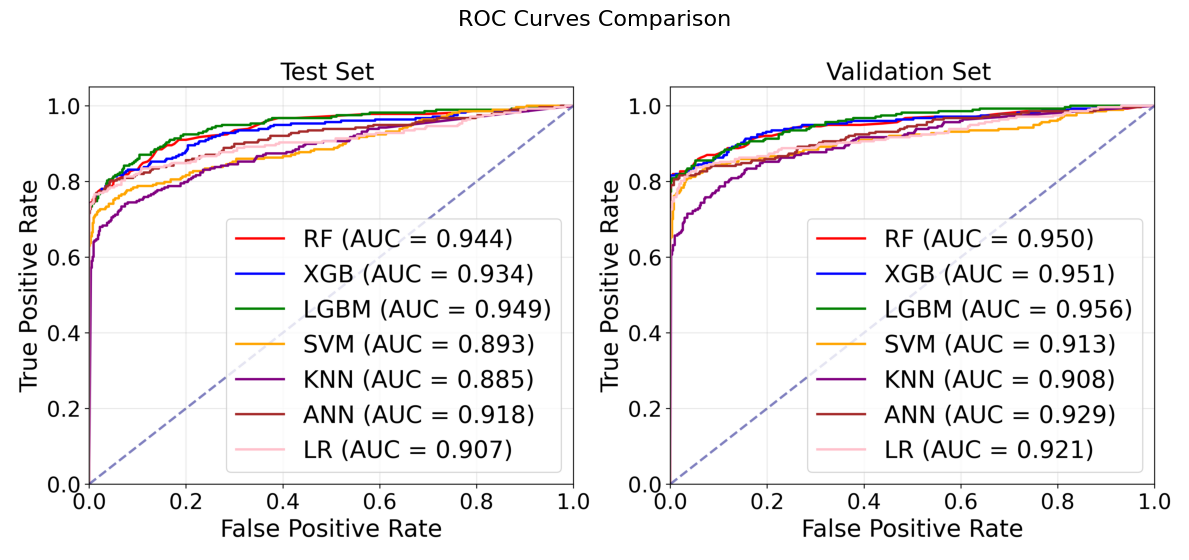

In [20]:
    # ---------------------------
    # Plot ROC Curves
    # ---------------------------
    def plot_roc_curves(results_dict, dataset_type, ax):
        """Plot ROC curves for specified dataset type"""
        # Set font sizes
        title_fontsize = 20
        label_fontsize = 20
        legend_fontsize = 20
        tick_fontsize = 18
        
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
        
        for i, (model_name, result) in enumerate(results_dict.items()):
            if result['error'] or result[f'roc_{dataset_type.lower()}'] is None:
                continue
            
            # Get ROC curve data
            if dataset_type.lower() == 'test':
                fpr, tpr, roc_auc = result['roc_test']
            else:  # validation
                fpr, tpr, roc_auc = result['roc_val']
            
            # Plot ROC curve
            ax.plot(fpr, tpr, color=colors[i % len(colors)], 
                    lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
        
        # Plot diagonal line
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=label_fontsize)
        ax.set_ylabel('True Positive Rate', fontsize=label_fontsize)
        ax.set_title(f'{dataset_type} Set', fontsize=title_fontsize)
        ax.legend(loc="lower right", fontsize=legend_fontsize)
        ax.grid(True, alpha=0.3)
        
        # Set tick font size
        ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot test set ROC curves
    plot_roc_curves(all_results, 'Test', ax1)
    
    # Plot validation set ROC curves
    plot_roc_curves(all_results, 'Validation', ax2)
    
    # Save ROC curve image
    plt.savefig('ROC_curves_comparison.png', dpi=300, bbox_inches='tight')
    # plt.savefig('ROC_curves_comparison.pdf', bbox_inches='tight')
    plt.show()

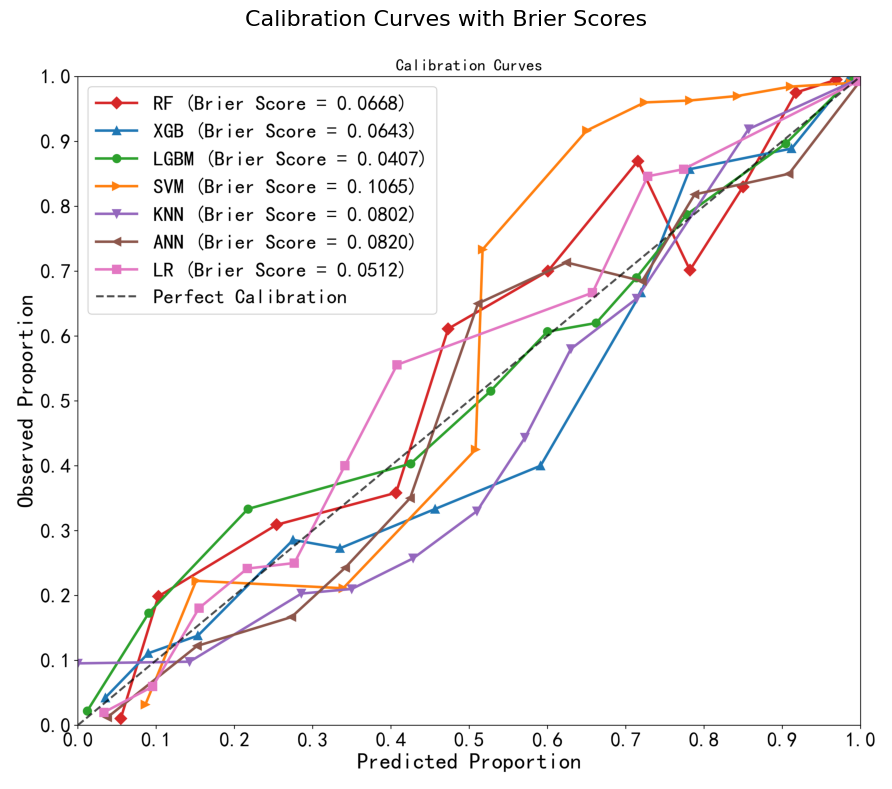

In [28]:
# ---------------------------
# Calibration Curves and Brier Scores
# ---------------------------
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def calculate_calibration_data(results_dict, X_test, y_test):
    """Calculate calibration data for all models"""
    calibration_data = []
    brier_scores = {}
    
    for model_name, result in results_dict.items():
        if result['error'] or result['final_model'] is None:
            continue
            
        # Get selected features and make predictions
        X_test_sel = result['selector'].transform(X_test)
        
        if hasattr(result['final_model'], "predict_proba"):
            y_proba = result['final_model'].predict_proba(X_test_sel)[:, 1]
        else:
            y_proba = result['final_model'].decision_function(X_test_sel)
            # Scale to probabilities if using decision function
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            y_proba = scaler.fit_transform(y_proba.reshape(-1, 1)).flatten()
        
        # Calculate calibration curve
        true_prob, pred_prob = calibration_curve(y_test, y_proba, n_bins=10, strategy='quantile')
        
        # Store calibration data
        for true, pred in zip(true_prob, pred_prob):
            calibration_data.append({
                'Model': model_name,
                'True_Probability': true,
                'Predicted_Probability': pred
            })
        
        # Calculate Brier score
        brier_scores[model_name] = brier_score_loss(y_test, y_proba)
    
    return pd.DataFrame(calibration_data), brier_scores

# Calculate calibration data and Brier scores
calibration_data, brier_scores = calculate_calibration_data(all_results, X_test, y_test)

# Define colors and markers for calibration curves
colors = {
    'RF': '#d62728',    # red
    'XGB': '#1f77b4',   # blue
    'LGBM': '#2ca02c',   # green
    'SVM': '#ff7f0e',   # orange
    'KNN': '#9467bd',   # purple
    'ANN': '#8c564b',   # brown
    'LR': '#e377c2',    # pink
}

markers = {
    'LGBM': 'o',
    'LR': 's',
    'XGB': '^',
    'RF': 'D',
    'KNN': 'v',
    'ANN': '<',
    'SVM': '>'
}

# Create calibration curve plot
plt.figure(figsize=(12, 10))

# Plot calibration curves for each model
models = calibration_data['Model'].unique()

for model in models:
    model_data = calibration_data[calibration_data['Model'] == model]
    
    # Sort by predicted probability
    model_data = model_data.sort_values('Predicted_Probability')
    
    # Get color and marker
    color = colors.get(model, '#000000')
    marker = markers.get(model, 'o')
    
    # Plot calibration curve
    plt.plot(model_data['Predicted_Probability'], 
             model_data['True_Probability'], 
             marker=marker, 
             linewidth=2.5,
             markersize=8,
             color=color,
             label=f'{model} (Brier Score = {brier_scores[model]:.4f})')

# Plot perfect calibration line (diagonal)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.7, label='Perfect Calibration')

# Set plot properties
plt.xlabel('Predicted Proportion', fontsize=22, fontweight='bold')
plt.ylabel('Observed Proportion', fontsize=22, fontweight='bold')
plt.title('Calibration Curves', fontsize=24, fontweight='bold')

# Set legend
plt.legend(loc='upper left', fontsize=14, framealpha=0.9)

# Set axis limits
plt.xlim([0, 1])
plt.ylim([0, 1])

# Set axis ticks
plt.xticks(np.arange(0, 1.1, 0.1), fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20)

# Add grid
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Save high-quality images
plt.savefig('calibration_curves_with_brier_scores.png', dpi=300, bbox_inches='tight')
plt.savefig('calibration_curves_with_brier_scores.pdf', bbox_inches='tight')

# Display plot
plt.show()

# Print Brier Score ranking
sorted_scores = sorted(brier_scores.items(), key=lambda x: x[1])
for i, (model, score) in enumerate(sorted_scores, 1):

In [24]:
    # ---------------------------
    # Print Final Summary
    # ---------------------------
    print("\n=== Model Training Summary ===")
     
    # Print each model's information
    for name, res in all_results.items():
        print(f"\nModel: {name}")
        if res['error']:
            print("  ERROR:", res['error'])
            continue
        
        print("  Selected features indices:", res['selected_features_idx'])
        
        # Print feature names
        feature_names_list = [feature_names[idx] for idx in res['selected_features_idx']]
        print("  Selected features names:", feature_names_list)
        
        print("  Best params:", res['best_params'])
        print("  Test metrics:", res['metrics_test'])
        print("  Val metrics:", res['metrics_val'])
        print("  Number of selected features:", len(res['selected_features_idx']))
    
    print("\n=== Training Completed ===")


=== Model Training Summary ===

Model: RF
  Selected features indices: [0, 2, 3, 4, 5, 9, 10, 13, 17, 18, 19, 23, 24, 25, 27, 28, 29, 30]
  Selected features names: ['Age', 'Area', 'Killip', 'Hbp', 'DM', 'Cpd', 'Carvds', 'Smoking_index', 'SBP', 'DBP', 'BMI', 'HDL-C', 'DLD-C', 'UA', 'NT_proBNP', 'cTnI', 'CK-MB', 'MYO']
  Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
  Test metrics: {'AUC': 0.944296606185293, 'Accuracy': 0.9333333333333333, 'Precision': 0.908713692946058, 'Recall': 0.7906137184115524, 'F1-Score': 0.8455598455598456}
  Val metrics: {'AUC': 0.949799637946909, 'Accuracy': 0.9333333333333333, 'Precision': 0.921964285714286, 'Recall': 0.754992805755396, 'F1-Score': 0.8406374501992031}
  Number of selected features: 18

=== Training Completed ===

Model: XGB
  Selected features indices: [0, 1, 3, 4, 5, 12, 13, 18, 19, 22, 23, 24, 25, 27, 28, 29, 30]
  Selected features names: ['Age', 'Sex', 'Killip', 'Hbp', 'DM', 'Hbp_inheritance', 'Smoking_ind